# Introduction to vector databases on S&P 500 news

 # 📌 Objectives

 By the end of this notebook, students will be able to:

 1. **Load and Explore Financial News Data:**
    - Load a preprocessed dataset of financial news headlines and summaries related to S&P 500 companies.
    - Inspect and structure relevant metadata including publication date, ticker, and provider.

 2. **Build a Custom Vector Store:**
    - Combine title and summary text for embedding.
    - Implement a vector store from scratch with support for semantic search and optional metadata-based filtering using cosine similarity.

 3. **Generate and Use Sentence Embeddings:**
    - Apply a pre-trained transformer model (all-MiniLM-L6-v2) to encode text into embeddings for semantic analysis.

 4. **Perform Semantic Search with Filtering:**
    - Retrieve the most relevant news documents for a given query using both full-dataset and metadata-filtered searches.

 5. **Analyze Semantic Search Results:**
    - Interpret and visualize results of search queries (e.g., "AI announcement").
    - Identify temporal patterns and ticker frequency among top-ranked results.

 6. **Implement a FAISS-Based Vector Store:**
    - Normalize embeddings and use FAISS (IndexFlatIP) to enable efficient similarity search at scale.
    - Compare FAISS-based search results with custom vector store results.

 7. **Critically Compare Search Systems:**
    - Evaluate differences in similarity computation, speed, and scalability between custom and FAISS-based systems.
    - Reflect on design trade-offs for real-world vector search systems.

## Install and Import important librairies

In [ ]:
%pip install sentence-transformers
%pip install faiss-cpu

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

## Load news data

Load the provided news dataset and inspect the contents.

 👉 **Instructions**:
 - Load the CSV file named df_news.csv into a pandas DataFrame.
 - Convert the PUBLICATION_DATE column to a proper date format (not datetime).
 - Display the first few rows to understand the data structure. The key columns you’ll be using are:
   - TITLE
   - SUMMARY
   - TICKER
   - PROVIDER
   - PUBLICATION_DATE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/FZ4025 - Fintech e innovación digital en finanzas/Week 3/"
os.chdir(DIR)

df_news = pd.read_csv('df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


## Implement custom vector store

You will now implement a basic vector store from scratch. This class will allow you to:
1. Store embedded text and metadata.
2. Perform filtered semantic search using cosine similarity.

 👉 **Instructions**:

### Step 1: Prepare Documents
 - Combine the TITLE and SUMMARY columns into a single column named EMBEDDED_TEXT.
 - This combined text will be embedded later.

### Step 2: Load Embedding Model
 - Load the 'all-MiniLM-L6-v2' model from sentence-transformers.

### Step 3: Define CustomVectorStore Class
 Implement the class with the following methods (functions):

 - '__init__': Accepts an embedding model, list of documents, and corresponding metadata. Computes and stores embeddings for all documents.
 - search: Takes a query and returns the top k most similar documents, optionally filtered using metadata.
   - If a metadata_filter function is provided, apply it before computing similarity.
   - Use cosine similarity to compute distances.
   - Return the top k results as tuples of: (document, metadata, similarity score).

 ✅ **Requirements**:
 - Ensure the number of documents matches the number of metadata entries.
 - Make use of sklearn.metrics.pairwise.cosine_similarity.

You will test your class at the end.

In [ ]:
# CODE HERE
# Use as many coding cells as you need

df_news['EMBEDDED_TEXT'] = df_news['TITLE'].fillna('') + '. ' + df_news['SUMMARY'].fillna('')
texts = df_news['EMBEDDED_TEXT'].tolist()
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,EMBEDDED_TEXT
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...,2 Dow Jones Stocks with Promising Prospects an...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...,3 S&P 500 Stocks Skating on Thin Ice. The S&P ...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...,3M Rises 15.8% YTD: Should You Buy the Stock N...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...,3 Cash-Producing Stocks with Questionable Fund...
...,...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...,2 Dividend Stocks to Buy With $500 and Hold Fo...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...,Zoetis (ZTS) Upgraded to Buy: Here's Why. Zoet...


In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
class CustomVectorStore:
    def __init__(self, embedding_model, documents, metadata):
        assert len(documents) == len(metadata), "Documents and metadata must be the same length"
        self.embedding_model = embedding_model
        self.documents = documents
        self.metadata = metadata
        self.embeddings = self.embedding_model.encode(documents, convert_to_numpy=True, normalize_embeddings=True)

    def search(self, query, k, metadata_filter=None):
        if metadata_filter:
            filtered_indices = [i for i, meta in enumerate(self.metadata) if metadata_filter(meta)]
            if not filtered_indices:
                return []
            filtered_docs = [self.documents[i] for i in filtered_indices]
            filtered_meta = [self.metadata[i] for i in filtered_indices]
            filtered_embeds = self.embeddings[filtered_indices]
        else:
            filtered_docs = self.documents
            filtered_meta = self.metadata
            filtered_embeds = self.embeddings

        query_vec = self.embedding_model.encode([query], convert_to_numpy=True, normalize_embeddings=True)

        similarities = cosine_similarity(query_vec, filtered_embeds)[0]
        top_k_idx = np.argsort(similarities)[::-1][:k]

        results = [
            (filtered_docs[i], filtered_meta[i], float(similarities[i]))
            for i in top_k_idx
        ]
        return results



## Create and populate the vector store

 👉 **Instructions**:
 - Convert the combined EMBEDDED_TEXT column into a list of strings.
 - Create a metadata list of dictionaries for each document with keys:
   - 'PUBLICATION_DATE'
   - 'TICKER'
   - 'PROVIDER'
 - Instantiate your CustomVectorStore using:
   - The embedding model.
   - The list of document strings.
   - The metadata list.

 After initializing the store, you should be able to perform searches using:
'store.search("Apple earnings", k=3)'


In [ ]:
# CODE HERE
# Use as many coding cells as you need

documents = df_news['EMBEDDED_TEXT'].fillna('').tolist()
metadata = df_news[['PUBLICATION_DATE', 'TICKER', 'PROVIDER']].to_dict(orient='records')

In [ ]:
store = CustomVectorStore(model, documents, metadata)

In [ ]:
results = store.search("Apple earnings", k=3)

for doc, meta, score in results:
    print(f"\n PUBLICATION_DATE: {meta['PUBLICATION_DATE']} | TICKER: {meta['TICKER']} | PROVIDER: {meta['PROVIDER']}")
    print(f"- Similarity Score: {score:.4f}")
    print(f"- Document: {doc}")



 PUBLICATION_DATE: 2025-05-28 | TICKER: HUM | PROVIDER: Simply Wall St.
- Similarity Score: 0.5784
- Document: Humana (NYSE:HUM) Sees Revenue Increase in First-Quarter Earnings to US$32,112 Million. Humana (NYSE:HUM) recently reported first-quarter earnings, showcasing a revenue increase from USD 29,611 million to USD 32,112 million and a net income rise from USD 741 million to USD 1,244 million. Despite this positive earning surge, the company's share price declined by 11% over the last quarter. This could be partially attributed to a lowered earnings guidance for year-end 2025 and a pause in its share repurchase program. The recent market environment, characterized by flat movements in...

 PUBLICATION_DATE: 2025-04-30 | TICKER: OKE | PROVIDER: Simply Wall St.
- Similarity Score: 0.5687
- Document: ONEOK (NYSE:OKE) Reports Q1 2025 Revenue Surge to US$8 Billion. ONEOK (NYSE:OKE) recently released its first-quarter earnings, reporting revenue of USD 8,043 million, a marked increase ye

## Using your vector store and analyzing the results

### Retrieve AI Announcements

 Now that your vector store is working, let's use it to retrieve relevant documents.

 👉 **Instructions**:
 - Perform a semantic search using the query `"AI announcement"` with `k=50` to retrieve the top 50 most relevant articles.
 - Display each result's:
   - `TICKER`
   - `PUBLICATION_DATE`
   - `PROVIDER`
   - Similarity score
   - Full document text


In [ ]:
# CODE HERE
# Use as many coding cells as you need

results = store.search("AI announcement", k=50)

for idx in range(len(results)):
    doc, meta, score = results[idx]
    print(f"\n• Result {idx + 1}")
    print(f"PUBLICATION_DATE: {meta['PUBLICATION_DATE']} | TICKER: {meta['TICKER']} | PROVIDER: {meta['PROVIDER']}")
    print(f"- Similarity Score: {score:.4f}")
    print(f"- Document: {doc}")


• Result 1
PUBLICATION_DATE: 2025-03-17 | TICKER: JKHY | PROVIDER: Insider Monkey
- Similarity Score: 0.5574
- Document: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik. We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]

• Result 2
PUBLICATION_DATE: 2025-05-27 | TICKER: ADBE | PROVIDER: Investor's Business Daily
- Similarity Score: 0.5518
- Document: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus.. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.

• Result 3
PUBLICATION_DATE: 2025-05-31 | TICKER: PLTR | PROVIDER: Motley Fool
- Similarity Score: 0.5283
- Document: Better Artifici

 ### **Q1.** What are the top companies (by TICKER) most frequently appearing in the top 50 search results for the query "AI announcement"?  
 Check their company names on Yahoo Finance. Are you surprised by the results?

 ✅ **Your task**:
 - Count the number of times each TICKER appears.
 - Print and analyze the top results.

In [ ]:
# CODE HERE
# Use as many coding cells as you need

tickers = [meta['TICKER'] for _, meta, _ in results]

ticker_counts = Counter(tickers)

print("Most frequent TICKERS on 'AI announcement':\n")
for ticker, count in ticker_counts.most_common():
    print(f"• {ticker}: {count} ocurrences")

Most frequent TICKERS on 'AI announcement':

• PLTR: 5 ocurrences
• BKR: 3 ocurrences
• AMD: 3 ocurrences
• QCOM: 2 ocurrences
• GOOG: 2 ocurrences
• AMZN: 2 ocurrences
• EXPE: 2 ocurrences
• MSFT: 2 ocurrences
• CTSH: 2 ocurrences
• INTC: 2 ocurrences
• JKHY: 1 ocurrences
• ADBE: 1 ocurrences
• WSM: 1 ocurrences
• CEG: 1 ocurrences
• RSG: 1 ocurrences
• NVDA: 1 ocurrences
• INTU: 1 ocurrences
• GOOGL: 1 ocurrences
• NFLX: 1 ocurrences
• YUM: 1 ocurrences
• SMCI: 1 ocurrences
• ORCL: 1 ocurrences
• META: 1 ocurrences
• ABNB: 1 ocurrences
• PYPL: 1 ocurrences
• CSCO: 1 ocurrences
• NOW: 1 ocurrences
• ROK: 1 ocurrences
• HPQ: 1 ocurrences
• DELL: 1 ocurrences
• CRM: 1 ocurrences
• IT: 1 ocurrences
• FFIV: 1 ocurrences
• AVGO: 1 ocurrences
• KMX: 1 ocurrences


YOUR WRITTEN RESPONSE HERE

I checked the names of the top 50 companies most frequently appearing on AI announcement on Yahoo Finance. Some of these are expected, especially PLTR (Palantir Technologies), AMD (Advanced Micro Devices), MSFT (Microsoft), NVDA (NVIDIA), and GOOG/GOOGL (Google), since they’re closely tied to AI development or infrastructure.

What did surprise me were companies like BKR (Baker Hughes) or EXPE (Expedia), since they’re not top companies when thinking about AI. In this case, maybe they had announcements related to adopting AI in their operations, which could explain their presence in the search results.

### **Q2.** What is the date range of the top 50 results? Are the articles evenly distributed across time?

 ✅ **Your task**:
 - Extract the publication dates of the top 50 results.
 - Plot a histogram to visualize the temporal distribution.
 - Reflect: Are these mentions clustered in recent months or spread evenly?

 🧠 **Follow-up**: What could explain the timing of increased AI announcements?

In [ ]:
# CODE HERE
# Use as many coding cells as you need
dates = [meta['PUBLICATION_DATE'] for _, meta, _ in results]
dates = [pd.to_datetime(date).date() for date in dates]

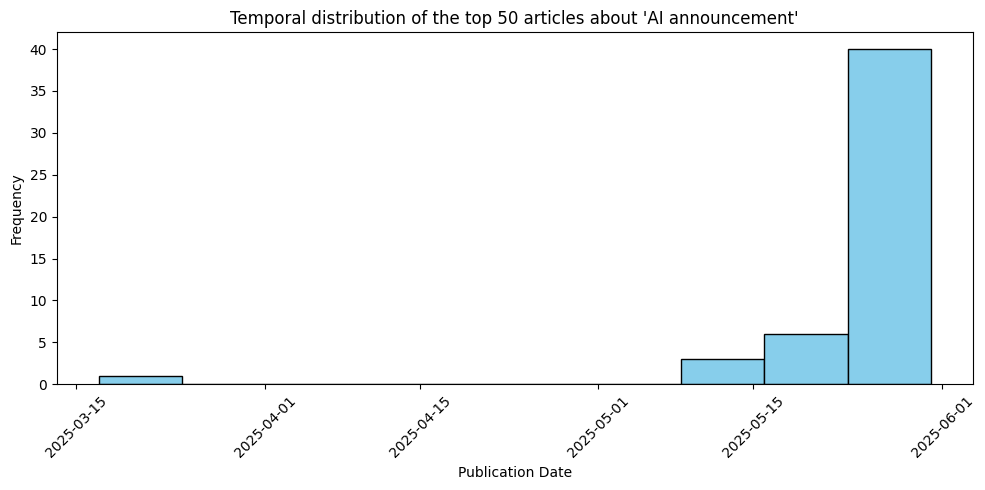

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(dates, bins=10, color='skyblue', edgecolor='black')
plt.title("Temporal distribution of the top 50 articles about 'AI announcement'")
plt.xlabel("Publication Date")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

YOUR WRITTEN RESPONSE HERE

The date range of the top 50 results spans from mid-March to the end of May 2025, but the articles are not evenly distributed over time. Most of them are concentrated in the last two weeks of May, showing a clear spike in AI-related announcements during that period. This suggests a recent surge in interest or activity around AI, possibly driven by quarterly earnings releases, new product announcements, or broader market trends. It's likely that major tech companies made AI-related moves around the same time, which triggered a wave of media coverage and public attention.


## Implement FAISS vector store

 We’ll now implement a **FAISS-based vector store**, designed for efficient similarity search at scale.

 👉 **Steps**:
 - Use the same sentence transformer model: all-MiniLM-L6-v2.
 - Encode your text into embessings
 - Normalize the vectors.

 FAISS supports multiple similarity types. For cosine similarity, we must:

 ✅ Normalize vectors to unit length  
 ✅ Use `IndexFlatIP` (inner product), because:
 - For normalized vectors, inner product = cosine similarity


In [ ]:
# CODE HERE
# Use as many coding cells as you need

document_embeddings = model.encode(documents, convert_to_numpy=True, normalize_embeddings=True)

We’ll now:
 - Initialize the FAISS index
 - Add the document embeddings

In [ ]:
# CODE HERE
# Use as many coding cells as you need

dimension = document_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(document_embeddings)

### Create a `FaissVectorStore` class with a `.search()` method.

 This method:
 - Encodes and normalizes the query
 - Optionally applies metadata filters
 - Returns top `k` results with similarity scores and metadata

In [ ]:
# CODE HERE
# Use as many coding cells as you need

class FaissVectorStore:
    def __init__(self, embedding_model, documents, metadata):
        assert len(documents) == len(metadata), "Documents and metadata must be the same length"

        self.embedding_model = embedding_model
        self.documents = documents
        self.metadata = metadata
        self.embeddings = embedding_model.encode(documents, convert_to_numpy=True, normalize_embeddings=True)

        dimension = self.embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dimension)
        self.index.add(self.embeddings)

    def search(self, query, k, metadata_filter=None):
        query_vec = self.embedding_model.encode([query], convert_to_numpy=True, normalize_embeddings=True)

        if metadata_filter:
            filtered_indices = [i for i, meta in enumerate(self.metadata) if metadata_filter(meta)]
            if not filtered_indices:
                return []

            filtered_embeds = self.embeddings[filtered_indices]
            temp_index = faiss.IndexFlatIP(filtered_embeds.shape[1])
            temp_index.add(filtered_embeds)

            scores, indices = temp_index.search(query_vec, k)
            results = [
                (self.documents[filtered_indices[i]], self.metadata[filtered_indices[i]], float(scores[0][i]))
                for i in range(len(indices[0]))
            ]
        else:
            scores, indices = self.index.search(query_vec, k)
            results = [
                (self.documents[i], self.metadata[i], float(scores[0][j]))
                for j, i in enumerate(indices[0])
            ]

        return results


 Let’s run a semantic search using FAISS:
 - Query: `"AI announcement"`
 - Top results: `k=50`

 Print out:
 - Ticker
 - Publication date
 - Provider
 - Cosine similarity score
 - Full text

In [ ]:
# CODE HERE
# Use as many coding cells as you need

faiss_store = FaissVectorStore(model, documents, metadata)

In [ ]:
results = faiss_store.search("AI announcement", k=50)

for idx, (doc, meta, score) in enumerate(results):
    print(f"\n• Result {idx + 1}")
    print(f"PUBLICATION_DATE: {meta['PUBLICATION_DATE']} | TICKER: {meta['TICKER']} | PROVIDER: {meta['PROVIDER']}")
    print(f"- Similarity Score: {score:.4f}")
    print(f"- Document: {doc}")


• Result 1
PUBLICATION_DATE: 2025-03-17 | TICKER: JKHY | PROVIDER: Insider Monkey
- Similarity Score: 0.5574
- Document: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik. We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]

• Result 2
PUBLICATION_DATE: 2025-05-27 | TICKER: ADBE | PROVIDER: Investor's Business Daily
- Similarity Score: 0.5518
- Document: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus.. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.

• Result 3
PUBLICATION_DATE: 2025-05-31 | TICKER: PLTR | PROVIDER: Motley Fool
- Similarity Score: 0.5283
- Document: Better Artifici

## Evaluation: Comparing FAISS Vector Store with your Custom Vector Store

### Retrieval Comparison Across Systems

 👉 **Instructions**:

 - Using the 5 'test_queries' provided in the list below, retrieve the top 5 news for each query using both your custom and FAISS vector stores.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).


In [ ]:
test_queries = [
    'Stock price drop',
    'Layoffs',
    'Mergers and acquisitions',
    'Fed interest rate',
    'Regulation',
    'Cryptocurrency'

]

In [ ]:
# CODE HERE
# Use as many coding cells as you need

for query in test_queries:
    print(f"\n{'='*80}")
    print(f"Query: {query}")
    print(f"{'='*80}")

    print("\n▸ 'all-MiniLM-L6-v2' Results:")
    custom_results = store.search(query, k=5)
    for idx, (doc, meta, score) in enumerate(custom_results):
        print(f"{idx + 1}. {meta['TICKER']} | {meta['PUBLICATION_DATE']} | {meta['PROVIDER']} | Score: {score:.4f}")
        print(f"- {doc}")

    print("\n▸ FaissVectorStore Results:")
    faiss_results = faiss_store.search(query, k=5)
    for idx, (doc, meta, score) in enumerate(faiss_results):
        print(f"{idx + 1}. {meta['TICKER']} | {meta['PUBLICATION_DATE']} | {meta['PROVIDER']} | Score: {score:.4f}")
        print(f"- {doc}")


Query: Stock price drop

▸ 'all-MiniLM-L6-v2' Results:
1. GNRC | 2025-05-28 | StockStory | Score: 0.5427
- 3 Industrials Stocks Walking a Fine Line. Even if they go mostly unnoticed, industrial businesses are the backbone of our country. Unfortunately, this role also comes with a demand profile tethered to the ebbs and flows of the broader economy, and investors seem to be forecasting a downturn - over the past six months, the industry has pulled back by 10.7%. This drop was worse than the S&P 500’s 1.9% fall.
2. NOW | 2025-05-29 | Zacks | Score: 0.5408
- ServiceNow (NOW) Stock Drops Despite Market Gains: Important Facts to Note. ServiceNow (NOW) reachead $1,015.23 at the closing of the latest trading day, reflecting a -0.59% change compared to its last close.
3. CRL | 2025-05-21 | StockStory | Score: 0.5395
- Guardant Health, Evolent Health, Charles River Laboratories, Avantor, and Lumen Stocks Trade Down, What You Need To Know. A number of stocks fell in the afternoon session after 

### **Q3.** Do you observe any significant differences in the top-5 retrieved results for each query between the two systems? Explain why these differences may or may not occur.

YOUR WRITTEN RESPONSE HERE

There are almost no significant differences between the top-5 results retrieved by the `all-MiniLM-L6-v2` model and the FaissVectorStore across all queries. In most cases, the rankings and similarity scores are identical, with only very slight variations in ordering or the last entry (e.g., "Cryptocurrency" where BAC appears in one and SCHW in the other). This consistency suggests that both systems are using the same underlying embeddings and similarity metric, and that the FAISS-based store is effectively replicating the semantic search behavior of the raw embedding + cosine similarity setup in the Custom Vector Store. Minor differences, when they occur, could be due to implementation details like rounding, internal indexing precision, or how ties in scores are handled.

## Evaluation: Comparing 2 embedding models with your Custom Vector Store

 👉 **Instructions**:

 - Implement your custom vector store with `'all-MiniLM-L6-v2'` model from `sentence-transformers`, and compare it with the `'all-mpnet-base-v2'` model from `sentence-transformers`.
 - Similarly, retrieve the top 5 news for each query using both implementations.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).

In [ ]:
# CODE HERE
# Use as many coding cells as you need

model_mpnet = SentenceTransformer('all-mpnet-base-v2')
store_mpnet = CustomVectorStore(model_mpnet, documents, metadata)

In [ ]:
for query in test_queries:
    print(f"\n{'='*80}")
    print(f"Query: {query}")
    print(f"{'='*80}")

    print("\n▸ 'all-MiniLM-L6-v2' Results:")
    minilm_results = store.search(query, k=5)
    for idx, (doc, meta, score) in enumerate(minilm_results):
        print(f"{idx + 1}. {meta['TICKER']} | {meta['PUBLICATION_DATE']} | {meta['PROVIDER']} | Score: {score:.4f}")
        print(f"- {doc}")

    print("\n▸ 'all-mpnet-base-v2' Results:")
    mpnet_results = store_mpnet.search(query, k=5)
    for idx, (doc, meta, score) in enumerate(mpnet_results):
        print(f"{idx + 1}. {meta['TICKER']} | {meta['PUBLICATION_DATE']} | {meta['PROVIDER']} | Score: {score:.4f}")
        print(f"- {doc}")


Query: Stock price drop

▸ 'all-MiniLM-L6-v2' Results:
1. GNRC | 2025-05-28 | StockStory | Score: 0.5427
- 3 Industrials Stocks Walking a Fine Line. Even if they go mostly unnoticed, industrial businesses are the backbone of our country. Unfortunately, this role also comes with a demand profile tethered to the ebbs and flows of the broader economy, and investors seem to be forecasting a downturn - over the past six months, the industry has pulled back by 10.7%. This drop was worse than the S&P 500’s 1.9% fall.
2. NOW | 2025-05-29 | Zacks | Score: 0.5408
- ServiceNow (NOW) Stock Drops Despite Market Gains: Important Facts to Note. ServiceNow (NOW) reachead $1,015.23 at the closing of the latest trading day, reflecting a -0.59% change compared to its last close.
3. CRL | 2025-05-21 | StockStory | Score: 0.5395
- Guardant Health, Evolent Health, Charles River Laboratories, Avantor, and Lumen Stocks Trade Down, What You Need To Know. A number of stocks fell in the afternoon session after 

### **Q4.**  Which embedding model performs better in retrieving relevant documents for the queries? Support your answer with specific examples from the results.

 YOUR WRITTEN RESPONSE HERE

 Between the two embedding models, `all-mpnet-base-v2` appears to perform better overall in retrieving relevant documents for the queries, based on higher similarity scores and greater topical precision in some results.

 For instance, in the query "stock price drop", `all-mpnet-base-v2` yields significantly higher scores (ALGN at 0.6400 and DHR at 0.6219), suggesting stronger semantic alignment with the query, while `all-MiniLM-L6-v2` peaks at 0.5427. Similarly, in "layoffs", `all-mpnet-base-v2` surfaces companies like IP and AVGO that are directly involved in recent workforce adjustments, while MiniLM overrepresents CVX across multiple entries, which may indicate redundancy rather than diversity in relevant examples.

 Thus, `all-mpnet-base-v2` not only yields higher cosine similarity scores across most queries but also demonstrates a better grasp of financial subtlety, making it a stronger choice for retrieving semantically relevant news.

## 🛠️ Implementation-Level Questions

### **Q5.**  What role does vector normalization play in each implementation?


 YOUR WRITTEN RESPONSE HERE

Vector normalization is critical in both the cosine similarity and FAISS-based implementations because it ensures that similarity calculations reflect true semantic alignment. When vectors are normalized to unit length, the inner product between them effectively becomes the cosine similarity, which measures the angle between the vectors rather than the magnitude. Without normalization, longer vectors could dominate the similarity score purely due to their length, regardless of their semantic content. Thus, normalization ensures that comparisons are based on meaning, not scale, leading to more reliable and interpretable results.


### **Q6.**  What would happen if vectors were not normalized before indexing?


 YOUR WRITTEN RESPONSE HERE

If vectors are not normalized before indexing, the similarity scores can become misleading. This is because the inner product will then depend on both the direction and the magnitude of the vectors. As a result, documents with larger norms might appear more similar than they actually are, even if their directions diverge significantly. This violates the assumption behind cosine similarity that only the direction of the vectors matters for measuring semantic similarity. Therefore, similarity scores no longer reflect true angular similarity and can be skewed by the length of the vectors, leading to inaccurate and biased retrieval results.



## 🧠 Critical Thinking / Design Choices


### **Q7.** Which implementation would you choose for a production-scale search system? Why?



 YOUR WRITTEN RESPONSE HERE

For a production-scale search system, I would choose the FAISS-based implementation. FAISS is specifically optimized for large-scale similarity search and provides highly efficient indexing structures like IndexFlatIP or IVF, which can handle millions of vectors with fast query times. It also supports GPU acceleration, which is crucial for scaling with minimal latency. In contrast, a manual similarity search using sklearn or brute-force methods becomes computationally expensive and impractical as data volume grows.




### **Q8.**   If your dataset grows from 5K to 5M articles, which implementation will scale better? Justify your answer.


 YOUR WRITTEN RESPONSE HERE

If the dataset grows from 5K to 5M articles, the FAISS implementation will scale significantly better. FAISS is designed to handle large-scale similarity search using optimized data structures and approximate nearest neighbor (ANN) algorithms. It uses indexing techniques like IVF that reduce search time and memory usage without losing much accuracy. Additionally, FAISS supports GPU acceleration, allowing for much faster computation over millions of vectors that other implementations, such as cosine_similarity from sklearn, scale poorly as the number of documents increase.